### Notebook for evaluating learning curves of mode1 experiments

For ~9500 graph experiments we have collected mode1 experiments after adjusting the hyperparameter ranges (see preliminary_experiments.ipynb). This notebook examines the learning curves of 3200 of the raphs to make sure the adjustment was effective. This time we remove experiments on graphs where a method has failed (a minor bug caused some methods to fail when we ran these experiments). Graph generation has also been slightly altered and a few new SSL methods have been introduced.

Note that we reuse the same experiments in our mode1 analysis. Hence the first 2 shards in results/mode1 are the same as we analyse here. However in results/mode1 we have removed the learning curves for better resource utilization (we do not examine learning curves after this notebook) 

In [1]:
import pandas as pd
import json
from evaluation_utils import read_processed_shards
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter

In [2]:
PROCESSED_DIR = f'results/mode1_learning_curves/processed'
df = read_processed_shards(PROCESSED_DIR, shard=2)

lines read for <_io.TextIOWrapper name='results/mode1_learning_curves/processed/shards/2.ndjson' mode='r' encoding='UTF-8'>


In [11]:
# Remove failed graphs
df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
df.dropna(axis=0, inplace=True)

In [12]:
def get_convergence(series, patience):
    return len(series) - patience

In [13]:
def get_max_patience(series):
    best = float('-inf')
    max_patience = 0
    last_improvement = 0
    for i in series:
        if i > best:
            best = i
            if last_improvement > max_patience:
                max_patience = last_improvement
            last_improvement = 0
        else:
            last_improvement += 1
    return max_patience

In [14]:
# Column constants
PRETEXT_LOSS = "pretext_losses"
DOWNSTREAM_TRAIN_LOSS = "downstream_train_losses"
DOWNSTREAM_VAL_LOSS = "downstream_val_losses"
DOWNSTREAM_TUNING_METRIC = "downstream_val_tuning_metrics"
TEST_METRIC = 'test_rocauc_ovr'
VAL_METRIC = 'val_rocauc_ovr'

BENCHMARK_PARAMS = ['train_downstream_lr', 'train_pretext_weight',
               'train_pretext_epochs', 'train_pretext_lr']
ENCODER_PARAMS = ['encoder_in_channels', 'encoder_hidden_channels', 'encoder_num_layers', 'encoder_dropout']
ALL_PARAMS = BENCHMARK_PARAMS + ENCODER_PARAMS

In [15]:
# Plots histogram for the validation metric (tuning metric) of each hyperparam in PARAMS
# Must have is a list of tuples, specifying if certain other parameters should have specific values 
def plot_performance_for_params(PARAMS, must_have = []):
    values = defaultdict(lambda: defaultdict(list))
    for i in range(len(df)):
        for p in PARAMS:
            p_cols = [col for col in df if p in col]
            for p_model in p_cols:
                model = p_model.removesuffix(f'_{p}')
                must_have_accepted = True
                for mh_p, mh_v_list in must_have:
                    result = df[f'{model}_{mh_p}'].iloc[i]
                    if result not in mh_v_list:
                        must_have_accepted = False
                        break
                if must_have_accepted:
                    p_value = df[p_model].iloc[i]
                    result = df[f'{model}_{VAL_METRIC}'].iloc[i]
                    values[p][p_value].append(result)
        
    for k,v in values.items():
        for k2,v2 in v.items():
            plt.hist(v2, label=k2, alpha=0.5, weights=np.ones(len(v2)) / len(v2))
            plt.title(k)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.legend()
        plt.show()

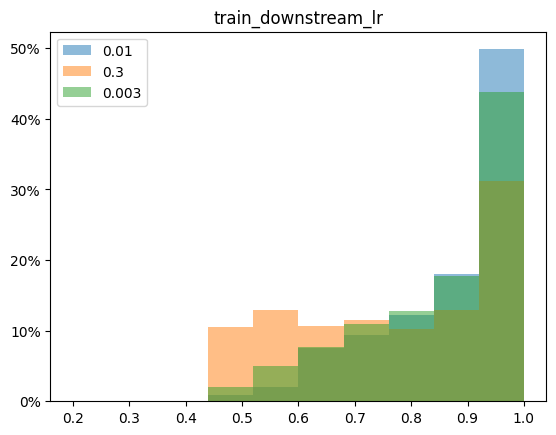

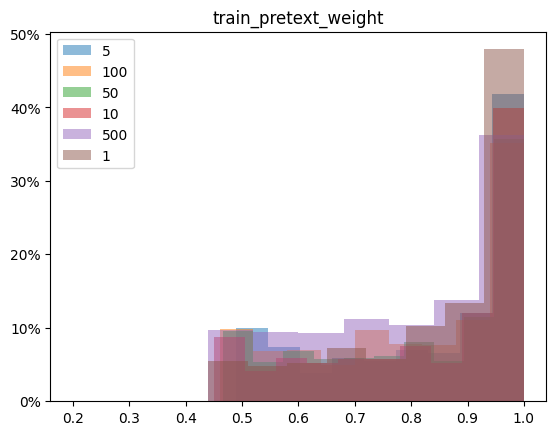

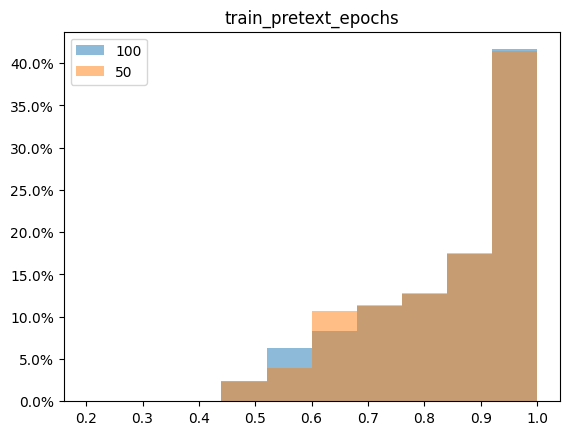

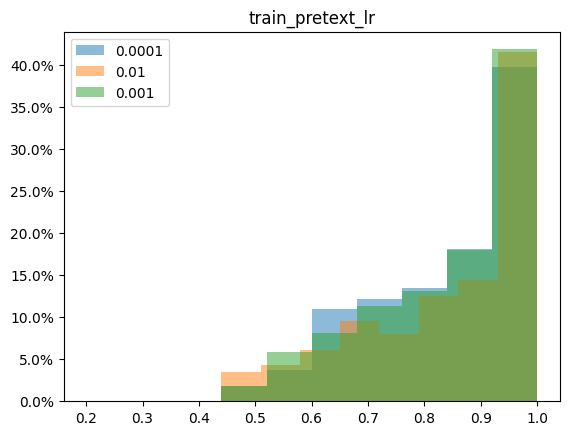

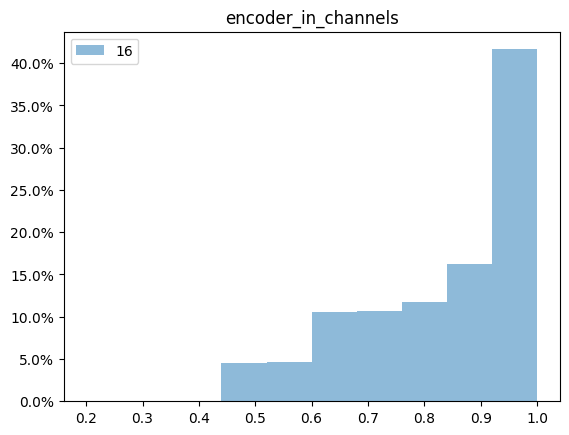

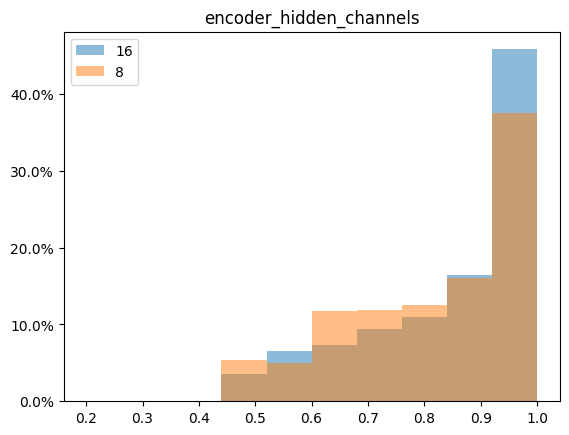

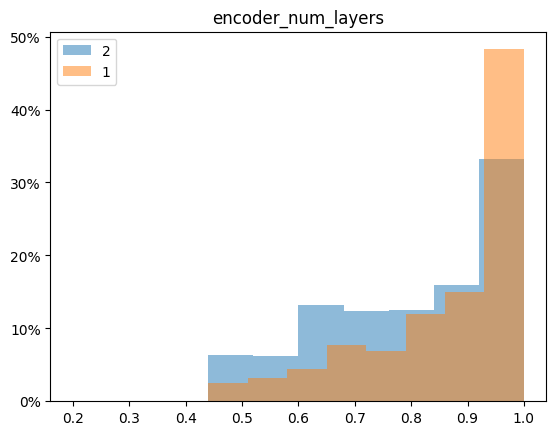

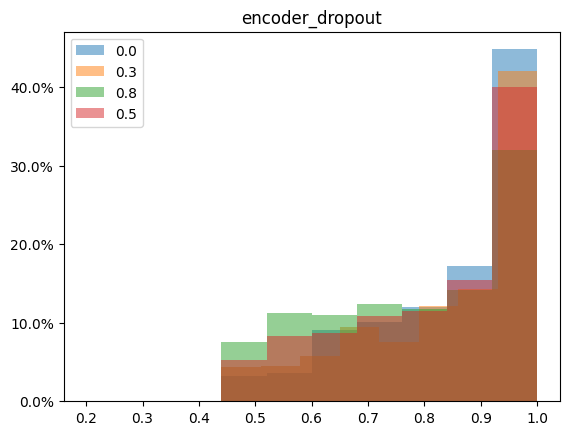

In [16]:
plot_performance_for_params(ALL_PARAMS)

In [20]:
# Evaluating downstream best epoch (convergence) and maximum patience combined for each training scheme
def plot_convergence_and_patience(must_have=[], bins=None):
    cols = [col for col in df if DOWNSTREAM_TUNING_METRIC in col]
    best_epoch_JL, max_patience_JL = [], []
    best_epoch_PF, max_patience_PF = [], []
    best_epoch_URL, max_patience_URL = [], []
    for col in cols:
        for i in range(len(df)):
            model = col.removesuffix(f'_{DOWNSTREAM_TUNING_METRIC}')
            must_have_accepted = True
            for mh_p, mh_v_list in must_have:
                result = df[f'{model}_{mh_p}'].iloc[i]
                if result not in mh_v_list:
                    must_have_accepted = False
                    break
            if must_have_accepted:
                metric_list = df[col].iloc[i]
                if metric_list is not None:
                    if "JL" in model:
                        best_epoch_JL.append(get_convergence(metric_list, 0))
                        max_patience_JL.append(get_max_patience(metric_list))
                    elif "PF" in model:
                        best_epoch_PF.append(get_convergence(metric_list, 0))
                        max_patience_PF.append(get_max_patience(metric_list))
                    elif "URL" in model:
                        best_epoch_URL.append(get_convergence(metric_list, 0))
                        max_patience_URL.append(get_max_patience(metric_list))
        
    plt.hist(best_epoch_JL, bins=bins, label="JL", alpha=0.5, weights=np.ones(len(best_epoch_JL)) / len(best_epoch_JL))
    plt.hist(best_epoch_PF, bins=bins, label="PF", alpha=0.5, weights=np.ones(len(best_epoch_PF)) / len(best_epoch_PF))
    plt.hist(best_epoch_URL, bins=bins, label="URL", alpha=0.5, weights=np.ones(len(best_epoch_URL)) / len(best_epoch_URL))
    plt.title("Training schemes best epoch")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()
    plt.show()

    plt.hist(max_patience_JL, bins=bins, label="JL", alpha=0.5, weights=np.ones(len(max_patience_JL)) / len(max_patience_JL))
    plt.hist(max_patience_PF, bins=bins, label="PF", alpha=0.5, weights=np.ones(len(max_patience_PF)) / len(max_patience_PF))
    plt.hist(max_patience_URL, bins=bins, label="URL", alpha=0.5, weights=np.ones(len(max_patience_URL)) / len(max_patience_URL))
    plt.title("Training schemes maximum patience")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()
    plt.show()


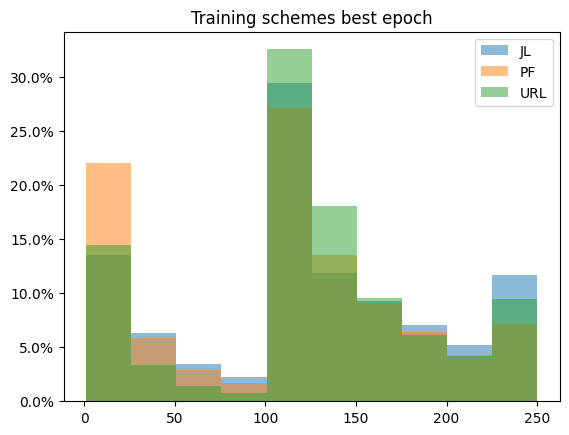

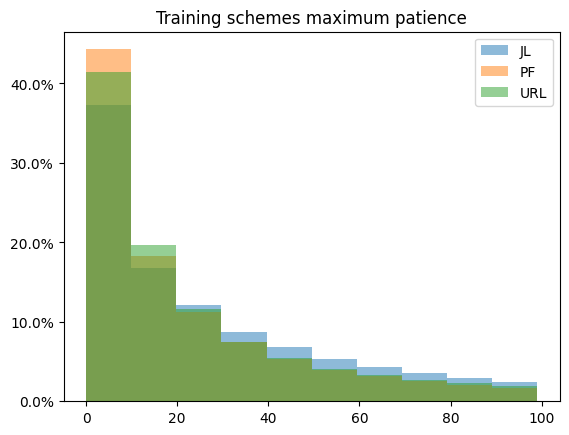

In [21]:
plot_convergence_and_patience()

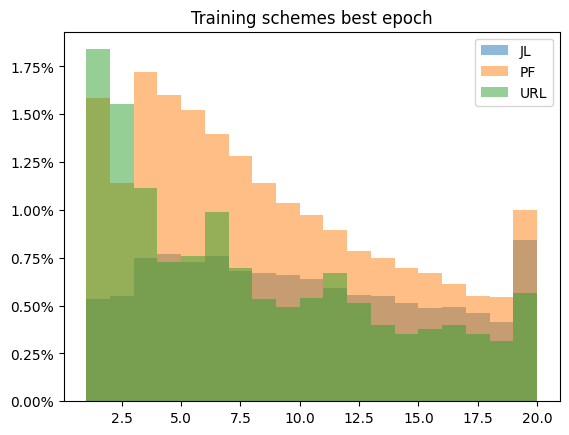

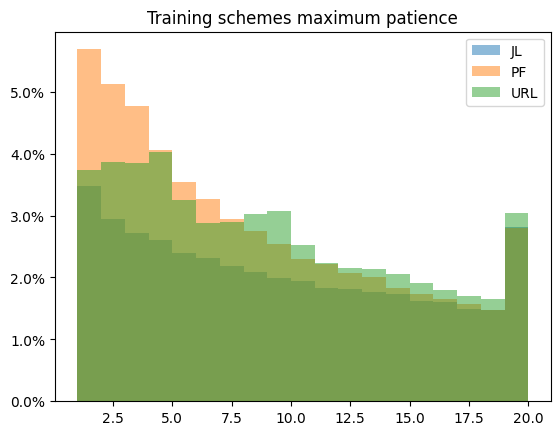

In [22]:
plot_convergence_and_patience(bins=range(1,21))